In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from Encoder import Encoder, reparameterize
from Generator import Generator
from Discriminator import BigJointDiscriminator

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

from tqdm.notebook import tqdm

In [2]:
class InvertiblePriorLinear(nn.Module):
    def __init__(self):
        super(InvertiblePriorLinear, self).__init__()
        self.p = nn.Parameter(torch.rand([2]))

    def forward(self, eps):
        o = self.p.data[0] * eps + self.p.data[1]
        return o
    def inverse(self, o):
        eps = (o - self.p.data[1])/self.p.data[0]
        return eps

class InvertiblePriorInv(nn.Module):
    """docstring for InvertiblePrior"""
    def __init__(self,prior):
        super(InvertiblePriorInv, self).__init__()
        self.prior = prior
    def forward(self, o):
        return self.prior.inverse(o)
    def inverse(self, eps):
        return self.prior(eps)


class SCM(nn.Module):
    def __init__(self, d, A=None, scm_type='mlp'):
        super().__init__()
        self.d = d
        self.A_given = A
        self.A_fix_idx = A == 0
        self.A = nn.Parameter(torch.zeros(d, d))

        prior_net_model = lambda : InvertiblePriorLinear()
        prior_net_enc_model = lambda x: InvertiblePriorInv(x)
        
        for i in range(d):
            setattr(self, "prior_net%d" % i, prior_net_model())
            setattr(self, "enc_net%d" % i, prior_net_enc_model(getattr(self, "prior_net%d" % i)))

    def set_zero_grad(self):
        if self.A_given is None:
            pass
        else:
            for i in range(self.d):
                for j in range(self.d):
                    if self.A_fix_idx[i, j]:
                        self.A.grad.data[i, j].zero_()

    def prior_nlr(self, z):
        '''Nonlinear transformation f_2(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "prior_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def enc_nlr(self, z):
        '''f_2^{-1}(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "enc_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def mask(self, z): # Az
        z = torch.matmul(z, self.A)
        return z

    def inv_cal(self, eps): # (I-A)^{-1}*eps
        adj_normalized = torch.inverse(torch.eye(self.A.shape[0], device=self.A.device) - self.A)
        z_pre = torch.matmul(eps, adj_normalized)
        return z_pre

    def get_eps(self, z):
        '''Returns epsilon from f_2^{-1}(z)'''
        return torch.matmul(z, torch.eye(self.A.shape[0], device=self.A.device) - self.A)

    def intervene(self, z, z_ori):
        # f_2^{-1}(z)
        z_ori = self.enc_nlr(z_ori)
        z = self.enc_nlr(z)
        # masked nonlinear z
        z_new = self.mask(z)
        z_new = z_new + self.get_eps(z_ori)
        return self.prior_nlr(z_new)

    def forward(self, eps=None, z=None):
        if eps is not None and z is None:
            # (I-A.t)^{-1}*eps
            z = self.inv_cal(eps) # n x d
            # nonlinear transform
            return self.prior_nlr(z)
        else:
            # f_2^{-1}(z)
            z = self.enc_nlr(z)
            # mask z
            z_new = self.mask(z) # new f_2^{-1}(z) (without noise)
            return z_new, z

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

def get_train_dataloader(root_folder, img_dim=64, batch_size=32, cols = None):

    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    training_data = ImageDataset(root_folder='sample_data/',transform=transform, cols = cols)
    train_dataloader = DataLoader(training_data, batch_size = batch_size)
    return train_dataloader

In [5]:
cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']

In [6]:
root_folder = 'sample_data/'

in_channels = 3
fc_size = 2048
latent_dim = 100

img_dim = 64
batch_size = 32

num_label = len(cols)

In [7]:
train_dataloader = get_train_dataloader(root_folder, img_dim=img_dim, batch_size=batch_size, cols = cols)

In [8]:
A = torch.zeros((num_label, num_label), device = device)
A[0, 2:6] = 1
A[1, 4] = 1

In [9]:
e = Encoder(latent_dim = latent_dim, fc_size = fc_size).to(device)
g = Generator(latent_dim = latent_dim, image_size = img_dim).to(device)
disc = BigJointDiscriminator(latent_dim = latent_dim, image_size = img_dim).to(device)

In [10]:
prior = SCM(num_label, A, scm_type='linscm').to(device)
prior_param = list(prior.parameters())
A_optimizer = optim.Adam(prior_param[0:1], lr=5e-4)
p_optimizer = optim.Adam(prior_param[1:],  lr=5e-4, betas=(0, 0.999))

In [11]:
e_optimizer = optim.Adam(e.parameters(), lr=5e-5, betas=(0, 0.999))
g_optimizer = optim.Adam(g.parameters(), lr=5e-5, betas=(0, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=1e-4, betas=(0, 0.999))

In [12]:
num = len(train_dataloader.dataset)//batch_size

epochs = 20

In [13]:
disc_steps = 1
g_steps = 1
e_steps = 1

celoss = torch.nn.BCEWithLogitsLoss()

In [14]:
for epoch in tqdm(range(epochs)):
    disc_loss, e_loss, g_loss = [], [], []
    
    e.train()
    g.train()
    disc.train()
    with torch.autograd.set_detect_anomaly(True):
        for (X, label) in tqdm(train_dataloader, total = num):        
            X = X.to(device)

            sup_flag = label[:, 0] != 0
            if sup_flag.sum() > 0:
                label = label[sup_flag, :].float()
            label = label.to(device)

            for _ in range(disc_steps):
                disc.zero_grad()

                z = torch.randn(X.shape[0], latent_dim, device=device)

                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)

                e_score = disc(X, z_fake.detach())
                g_score = disc(X_fake.detach(), z.detach())

                del z_fake
                del X_fake

                loss_d = F.softplus(g_score).mean() + F.softplus(-e_score).mean()
                loss_d.backward()
                d_optimizer.step()
                disc_loss.append(loss_d.item())

            #___________________________________
            for _ in range(e_steps):
                z = torch.randn(X.size(0), latent_dim, device=device)
                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                g.zero_grad()
                e.zero_grad()
                prior.zero_grad()

                e_score = disc(X, z_fake)
                l_encoder = e_score.mean()

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)
                label_z = mu[sup_flag, :num_label]
                sup_loss = celoss(label_z, label)

                l_encoder = l_encoder + sup_loss * 5
                l_encoder.backward()

                e_loss.append(l_encoder.item())
                e_optimizer.step()
                p_optimizer.step()

                g_score = disc(X_fake, z)
                s_decoder = torch.exp(g_score.detach()).clamp(0.5, 2)
                loss_decoder = -(s_decoder * g_score).mean()
                g_loss.append(loss_decoder.item())
                loss_decoder.backward()
                g_optimizer.step()

                prior.set_zero_grad()
                A_optimizer.step()
                p_optimizer.step()
        
        print(f"[{epoch+1}/{epochs}] Encoder Loss : {sum(e_loss)/num:>.5f} Gen Loss : {sum(g_loss)/num:>.5f} Disc Loss : {sum(disc_loss)/num:>.5f}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

[1/20] Encoder Loss : 3.97495 Gen Loss : 0.06646 Disc Loss : 1.23625


  0%|          | 0/316 [00:00<?, ?it/s]

[2/20] Encoder Loss : 3.86767 Gen Loss : 0.01353 Disc Loss : 1.25910


  0%|          | 0/316 [00:00<?, ?it/s]

[3/20] Encoder Loss : 3.91290 Gen Loss : 0.06387 Disc Loss : 1.17990


  0%|          | 0/316 [00:00<?, ?it/s]

[4/20] Encoder Loss : 3.95173 Gen Loss : 0.11327 Disc Loss : 1.13088


  0%|          | 0/316 [00:00<?, ?it/s]

[5/20] Encoder Loss : 3.63864 Gen Loss : 0.10769 Disc Loss : 1.15828


  0%|          | 0/316 [00:00<?, ?it/s]

[6/20] Encoder Loss : 3.29815 Gen Loss : 0.08285 Disc Loss : 1.18287


  0%|          | 0/316 [00:00<?, ?it/s]

[7/20] Encoder Loss : 3.06120 Gen Loss : 0.09528 Disc Loss : 1.20107


  0%|          | 0/316 [00:00<?, ?it/s]

[8/20] Encoder Loss : 2.95040 Gen Loss : 0.07057 Disc Loss : 1.21062


  0%|          | 0/316 [00:00<?, ?it/s]

[9/20] Encoder Loss : 2.85517 Gen Loss : 0.05409 Disc Loss : 1.22252


  0%|          | 0/316 [00:00<?, ?it/s]

[10/20] Encoder Loss : 2.79293 Gen Loss : 0.06283 Disc Loss : 1.23448


  0%|          | 0/316 [00:00<?, ?it/s]

[11/20] Encoder Loss : 2.74540 Gen Loss : 0.07314 Disc Loss : 1.23226


  0%|          | 0/316 [00:00<?, ?it/s]

[12/20] Encoder Loss : 2.73225 Gen Loss : 0.07560 Disc Loss : 1.22896


  0%|          | 0/316 [00:00<?, ?it/s]

[13/20] Encoder Loss : 2.71450 Gen Loss : 0.08718 Disc Loss : 1.21901


  0%|          | 0/316 [00:00<?, ?it/s]

[14/20] Encoder Loss : 2.73866 Gen Loss : 0.09941 Disc Loss : 1.21192


  0%|          | 0/316 [00:00<?, ?it/s]

[15/20] Encoder Loss : 2.77066 Gen Loss : 0.12037 Disc Loss : 1.19385


  0%|          | 0/316 [00:00<?, ?it/s]

[16/20] Encoder Loss : 2.74093 Gen Loss : 0.11721 Disc Loss : 1.18688


  0%|          | 0/316 [00:00<?, ?it/s]

[17/20] Encoder Loss : 2.78224 Gen Loss : 0.13249 Disc Loss : 1.17694


  0%|          | 0/316 [00:00<?, ?it/s]

[18/20] Encoder Loss : 2.80304 Gen Loss : 0.13885 Disc Loss : 1.16283


  0%|          | 0/316 [00:00<?, ?it/s]

[19/20] Encoder Loss : 2.76811 Gen Loss : 0.13788 Disc Loss : 1.16941


  0%|          | 0/316 [00:00<?, ?it/s]

[20/20] Encoder Loss : 2.81492 Gen Loss : 0.15123 Disc Loss : 1.14450


In [15]:
def plot_image(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

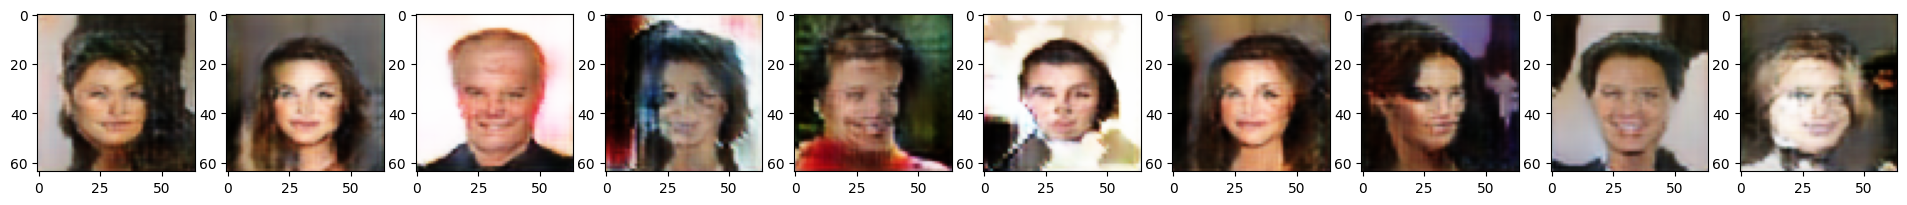

tensor([[ 1.1845,  0.6662,  0.0599,  1.2455, -0.5685,  0.2047],
        [ 0.5843,  0.6599,  0.0516,  0.8877,  0.7326,  2.0512],
        [ 0.9299,  0.6797,  0.0562,  1.1173,  0.1740,  0.2669],
        [ 1.1650,  0.6643,  0.0582,  1.2270,  0.2063, -0.1680],
        [ 2.6591,  0.6642,  0.0784,  2.0523, -3.5412, -3.9835],
        [ 0.2042,  0.6738,  0.0465,  0.8231,  1.4284,  2.0094],
        [ 0.2839,  0.6681,  0.0479,  0.7518,  1.0318,  2.1474],
        [ 1.0118,  0.6730,  0.0573,  1.1795, -0.4242, -0.2065],
        [ 2.2898,  0.7102,  0.0731,  1.9670, -2.7885, -3.5183],
        [ 2.8709,  0.6879,  0.0796,  1.9384, -3.3635, -3.9000]],
       device='cuda:0', grad_fn=<SliceBackward0>) tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
   

In [16]:
for X, label in train_dataloader:
    mu, sigma = e(X.to(device))
    z = reparameterize(mu, sigma)
    label_z = prior(z[:, :num_label])
    other_z = z[:, num_label:]
    z = torch.cat([label_z, other_z], dim=1)
    x_fake = g(z)
    x_fake = (x_fake * 0.5) + 0.5
    plot_image(x_fake)
    print(z[:10,:num_label], label[:10])
    break

In [18]:
prior.A

Parameter containing:
tensor([[ 0.0000,  0.0000,  1.1599,  1.6835, -2.5828, -2.6987],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.3280,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', requires_grad=True)